# DICOM
DICOM® — Digital Imaging and Communications in Medicine — is the international standard for medical images and related information. It defines the formats for medical images that can be exchanged with the data and quality necessary for clinical use.

DICOM® is implemented in almost every radiology, cardiology imaging, and radiotherapy device (X-ray, CT, MRI, ultrasound, etc.), and increasingly in devices in other medical domains such as ophthalmology and dentistry. With hundreds of thousands of medical imaging devices in use, DICOM® is one of the most widely deployed healthcare messaging Standards in the world. There are literally billions of DICOM® images currently in use for clinical care.

Since its first publication in 1993, DICOM® has revolutionized the practice of radiology, allowing the replacement of X-ray film with a fully digital workflow. Much as the Internet has become the platform for new consumer information applications, DICOM® has enabled advanced medical imaging applications that have “changed the face of clinical medicine”. From the emergency department, to cardiac stress testing, to breast cancer detection, DICOM® is the standard that makes medical imaging work — for doctors and for patients.

DICOM® is recognized by the International Organization for Standardization as the ISO 12052 standard.

https://www.dicomstandard.org/about


# FHIR
FHIR (Fast Healthcare Interoperability Resources) Specification, which is a standard for exchanging healthcare information electronically. 

https://www.hl7.org/fhir/overview.html

# De-identifying sensitive burnt-in text in DICOM images

1. Redact text Personal Health Information (PHI) present as pixels in DICOM images
2. Visually compare original DICOM images with their redacted versions


# Tools for Health Data Anonymization 
https://github.com/microsoft/Tools-for-Health-Data-Anonymization/tree/master


## Prerequisites
Before getting started, make sure presidio and the latest version of Tesseract OCR are installed. For detailed documentation, see the [installation docs](https://microsoft.github.io/presidio/installation).


Tesseract

```
sudo apt install tesseract-ocr
sudo apt install libtesseract-dev
```

```
tesseract --version

OUTPUT
tesseract 5.3.0
 leptonica-1.82.0
  libgif 5.2.1 : libjpeg 6b (libjpeg-turbo 2.1.2) : libpng 1.6.39 : libtiff 4.5.0 : zlib 1.2.13 : libwebp 1.2.4 : libopenjp2 2.5.0
 Found AVX2
 Found AVX
 Found FMA
 Found SSE4.1
 Found OpenMP 201511
 Found libarchive 3.6.2 zlib/1.2.13 liblzma/5.4.1 bz2lib/1.0.8 liblz4/1.9.4 libzstd/1.5.4
 Found libcurl/7.88.1 OpenSSL/3.0.14 zlib/1.2.13 brotli/1.0.9 zstd/1.5.4 libidn2/2.3.3 libpsl/0.21.2 (+libidn2/2.3.3) libssh2/1.10.0 nghttp2/1.52.0 librtmp/2.3 OpenLDAP/2.5.13
```

In [1]:
!pip install presidio_analyzer presidio_anonymizer presidio_image_redactor -q
!python -m spacy download en_core_web_lg -q 

  Using cached presidio_anonymizer-2.2.355-py3-none-any.whl.metadata (8.2 kB)
  Using cached phonenumbers-8.13.49-py2.py3-none-any.whl.metadata (10 kB)
  Using cached tldextract-5.1.3-py3-none-any.whl.metadata (11 kB)
  Using cached opencv_python-4.10.0.84-cp37-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (20 kB)
  Using cached spacy_legacy-3.0.12-py2.py3-none-any.whl.metadata (2.8 kB)
  Using cached spacy_loggers-1.0.5-py3-none-any.whl.metadata (23 kB)
  Using cached wasabi-1.1.3-py3-none-any.whl.metadata (28 kB)
  Using cached catalogue-2.0.10-py3-none-any.whl.metadata (14 kB)
  Using cached weasel-0.4.1-py3-none-any.whl.metadata (4.6 kB)
  Using cached pydantic-2.9.2-py3-none-any.whl.metadata (149 kB)
  Using cached langcodes-3.4.1-py3-none-any.whl.metadata (29 kB)
  Using cached requests_file-2.1.0-py2.py3-none-any.whl.metadata (1.7 kB)
  Using cached language_data-1.2.0-py3-none-any.whl.metadata (4.3 kB)
  Using cached pydantic_core-2.23.4-cp311-cp311-manylinux_2_1

## Dataset
Sample DICOM files are available for use in this notebook in `./sample_data`. Copies of the original DICOM data were saved into the folder with permission from the dataset owners. Please see the original dataset information below:
> Rutherford, M., Mun, S.K., Levine, B., Bennett, W.C., Smith, K., Farmer, P., Jarosz, J., Wagner, U., Farahani, K., Prior, F. (2021). A DICOM dataset for evaluation of medical image de-identification (Pseudo-PHI-DICOM-Data) [Data set]. The Cancer Imaging Archive. DOI: https://doi.org/10.7937/s17z-r072

In [1]:
import glob
from pathlib import Path
import matplotlib.pyplot as plt
import pydicom
from presidio_image_redactor import DicomImageRedactorEngine

## 1. Setup

In [2]:
def compare_dicom_images(
    instance_original: pydicom.dataset.FileDataset,
    instance_redacted: pydicom.dataset.FileDataset,
    figsize: tuple = (11, 11)
) -> None:
    """Display the DICOM pixel arrays of both original and redacted as images.

    Args:
        instance_original (pydicom.dataset.FileDataset): A single DICOM instance (with text PHI).
        instance_redacted (pydicom.dataset.FileDataset): A single DICOM instance (redacted PHI).
        figsize (tuple): Figure size in inches (width, height).
    """
    _, ax = plt.subplots(1, 2, figsize=figsize)
    ax[0].imshow(instance_original.pixel_array, cmap="gray")
    ax[0].set_title('Original')
    ax[1].imshow(instance_redacted.pixel_array, cmap="gray")
    ax[1].set_title('Redacted')

In [3]:
engine = DicomImageRedactorEngine()

## 2. Redacting from loaded DICOM image data

In cases where you already working with loaded DICOM data, the `.redact()` function is most appropriate.

In [4]:
# Load in and process your DICOM file as needed
dicom_instance = pydicom.dcmread('sample_data/0_ORIGINAL.dcm')

In [27]:
#dicom_instance.PixelData

In [11]:
dicom_instance

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 184
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 2.25.112784503178059210578740147414000844278
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', '100000']
(0008,0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008,0018) SOP Instance UID                    UI: 2.25.112784503178059210578740147414000844278
(0008,0020) Stu

In [6]:
dicom_instance.pixel_array.shape

(1760, 2140)

In [7]:
type(dicom_instance.pixel_array)

numpy.ndarray

In [10]:
dicom_instance.PatientName= "kkk"

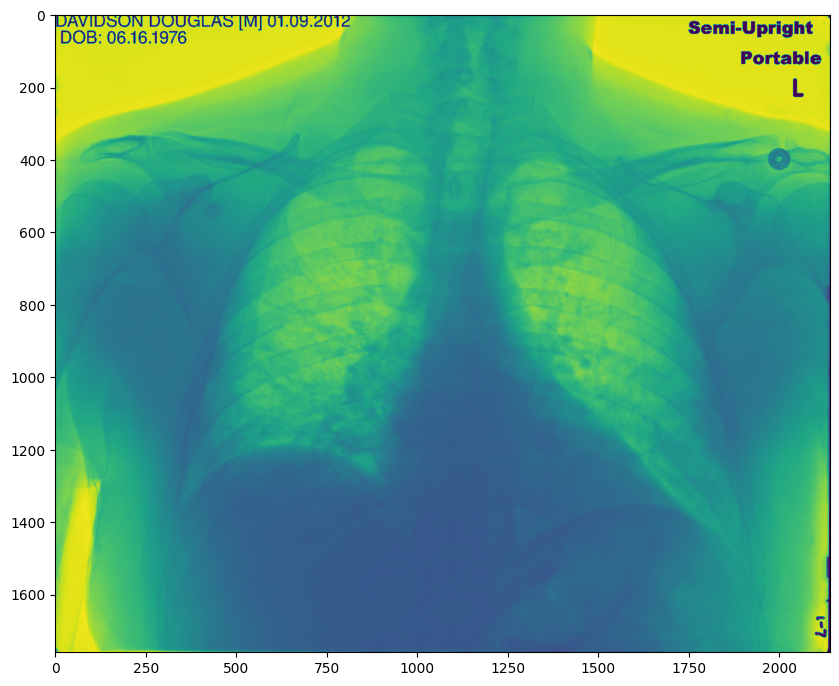

In [12]:

plt.figure(figsize=(10,10))
plt.imshow(dicom_instance.pixel_array)

In [13]:
# Redact
redacted_dicom_instance = engine.redact(dicom_instance, fill="contrast")

In [14]:
redacted_dicom_instance

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 184
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 2.25.112784503178059210578740147414000844278
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002,0013) Implementation Version Name         SH: '0.5'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', '100000']
(0008,0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008,0018) SOP Instance UID                    UI: 2.25.112784503178059210578740147414000844278
(0008,0020) Stu

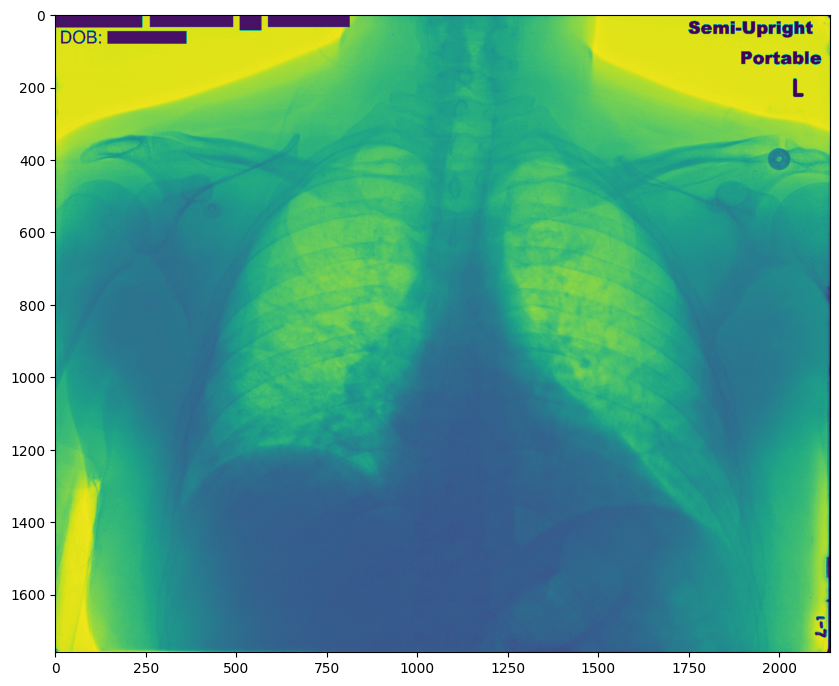

In [15]:

plt.figure(figsize=(10,10))
plt.imshow(redacted_dicom_instance.pixel_array)

In [16]:
# Option 2: Redact from a loaded DICOM image and return redacted regions
redacted_dicom_image2, bboxes = engine.redact_and_return_bbox(dicom_instance, fill="contrast")

In [17]:
bboxes

[{'left': 0, 'top': 0, 'width': 241, 'height': 37, 'entity_type': 'PERSON'},
 {'left': 262, 'top': 0, 'width': 230, 'height': 36, 'entity_type': 'PERSON'},
 {'left': 510, 'top': 0, 'width': 60, 'height': 45, 'entity_type': 'PERSON'},
 {'left': 588,
  'top': 1,
  'width': 226,
  'height': 35,
  'entity_type': 'DATE_TIME'},
 {'left': 145, 'top': 47, 'width': 218, 'height': 35, 'entity_type': 'PERSON'},
 {'left': 145,
  'top': 47,
  'width': 218,
  'height': 35,
  'entity_type': 'PHONE_NUMBER'}]

### 2.2 Verify performance
Let's look at the original input and compare against the de-identified output.

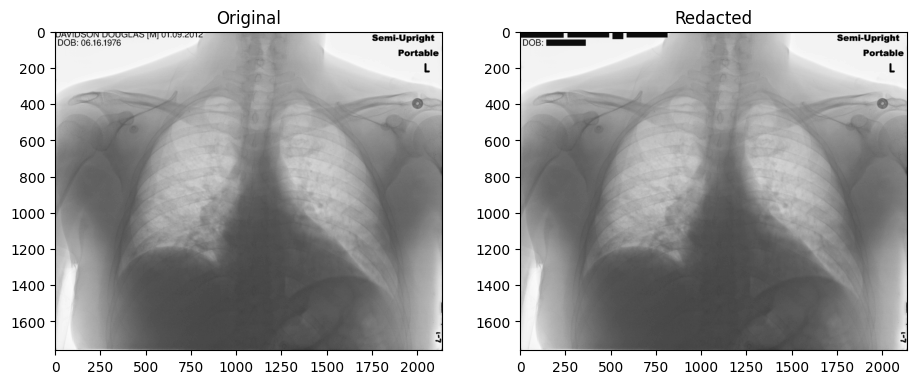

In [18]:
compare_dicom_images(dicom_instance, redacted_dicom_instance)

We can also set the "fill" to match the background color to blend in more with the image.

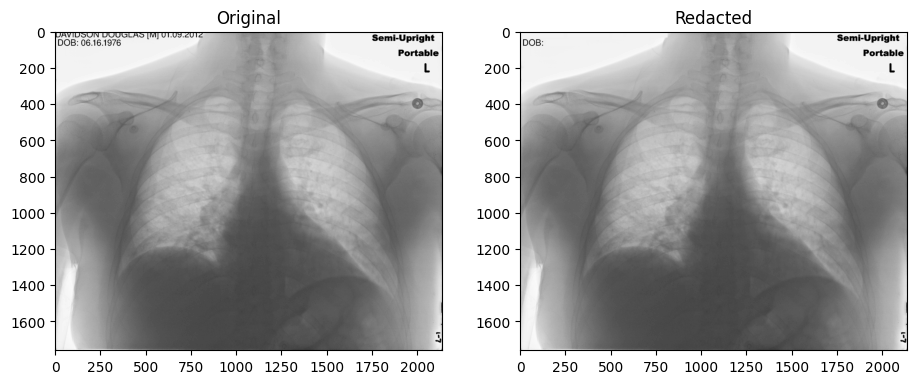

In [19]:
redacted_dicom_instance_2 = engine.redact(dicom_instance, fill="background")
compare_dicom_images(dicom_instance, redacted_dicom_instance_2)

### 2.3 Adjust parameters
With the `use_metadata` parameter, we can toggle whether the DICOM metadata is used to augment the analyzer which determines which text to redact.

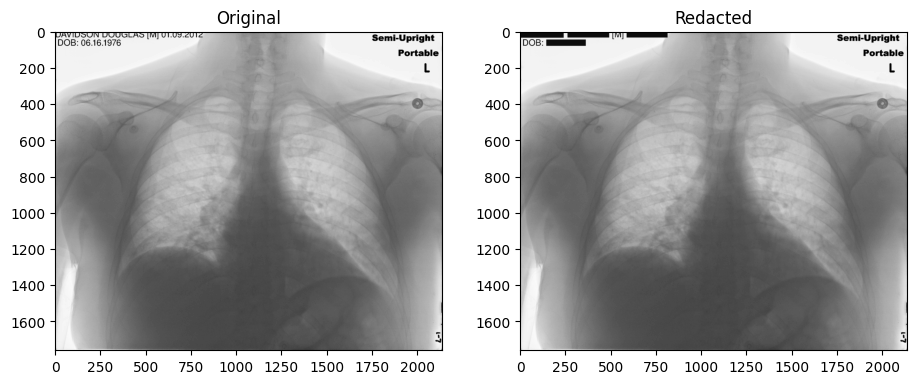

In [14]:
redacted_dicom_instance = engine.redact(dicom_instance, use_metadata=False) # default is use_metadata=True
compare_dicom_images(dicom_instance, redacted_dicom_instance)

We can also return the bounding box information for the pixel regions that were redacted.

Number of redacted regions: 6
[{'left': 0, 'top': 0, 'width': 241, 'height': 37, 'entity_type': 'PERSON'}, {'left': 262, 'top': 0, 'width': 230, 'height': 36, 'entity_type': 'PERSON'}, {'left': 510, 'top': 0, 'width': 60, 'height': 45, 'entity_type': 'PERSON'}, {'left': 588, 'top': 1, 'width': 226, 'height': 35, 'entity_type': 'DATE_TIME'}, {'left': 145, 'top': 47, 'width': 218, 'height': 35, 'entity_type': 'PERSON'}, {'left': 145, 'top': 47, 'width': 218, 'height': 35, 'entity_type': 'PHONE_NUMBER'}]


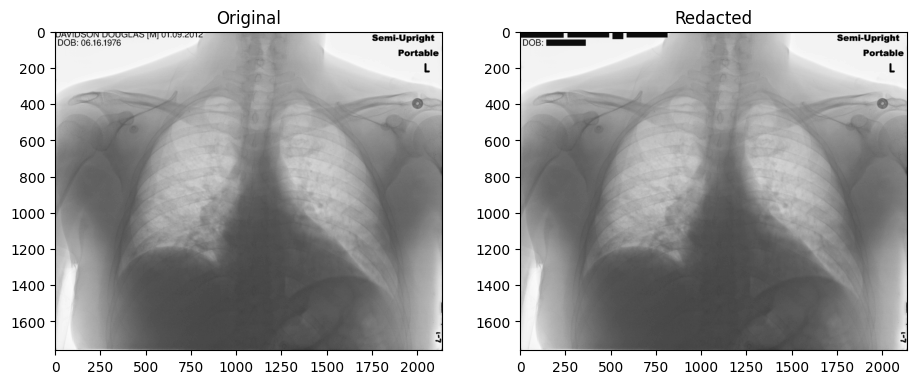

In [20]:
redacted_dicom_instance, bbox = engine.redact_and_return_bbox(dicom_instance)
compare_dicom_images(dicom_instance, redacted_dicom_instance)
print(f"Number of redacted regions: {len(bbox)}")
print(bbox)

## 3. Redacting from DICOM files
Before instantiating your `DicomImageRedactorEngine` class, determine where you want your input to come from and where you want your output to be written to.

To protect against overwriting the original DICOM files, the `redact_from_file()` and `redact_from_directory()` methods will not run if the `output_dir` is a directory which already contains any content.

In [21]:
# Single DICOM (.dcm) file or directory containing DICOM files
input_path = 'sample_data/'

# Directory where the output will be written
output_parent_dir = 'output/'

### 3.1. Run de-identification
Use the `DicomImageRedactorEngine` class to process your DICOM images. If you have only one image to process and want to specify that directly instead of a directory, use `.redact_from_file()` instead of `.redact_from_directory()`.

In [22]:
# Redact text PHI from DICOM images
engine.redact_from_directory(
    input_dicom_path = input_path,
    output_dir = output_parent_dir,
    fill="contrast",
    save_bboxes=True # if True, saves the redacted region bounding box info to .json files in the output dir
)

Output written to output/sample_data


Get file paths

In [23]:
# Original DICOM images
p = Path(input_path).glob("**/*.dcm")
original_files = [x for x in p if x.is_file()]

# Redacted DICOM images
p = Path(output_parent_dir).glob("**/*.dcm")
redacted_files = [x for x in p if x.is_file()]

Preview images

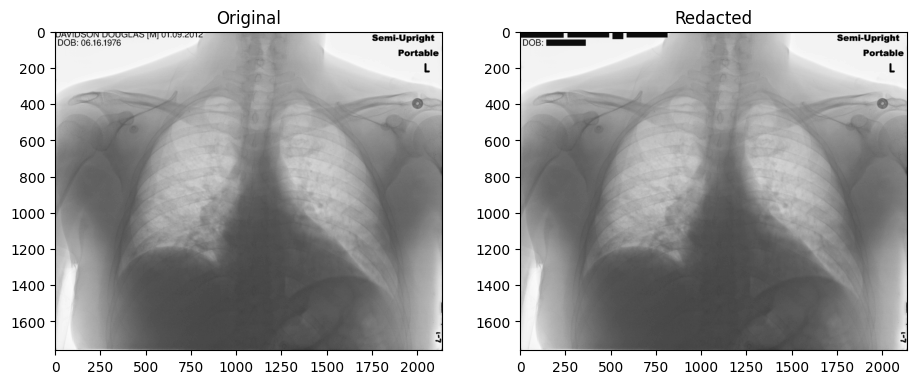

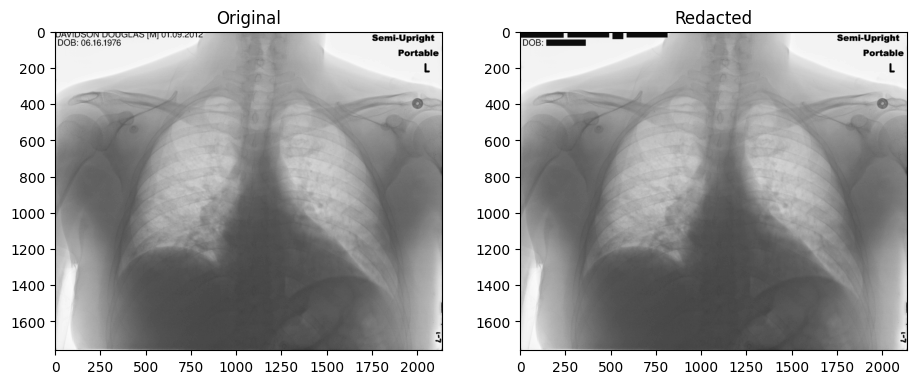

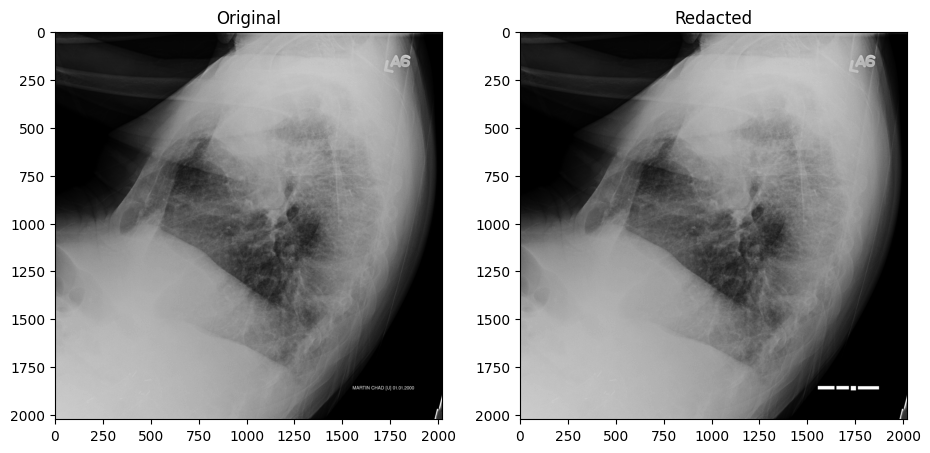

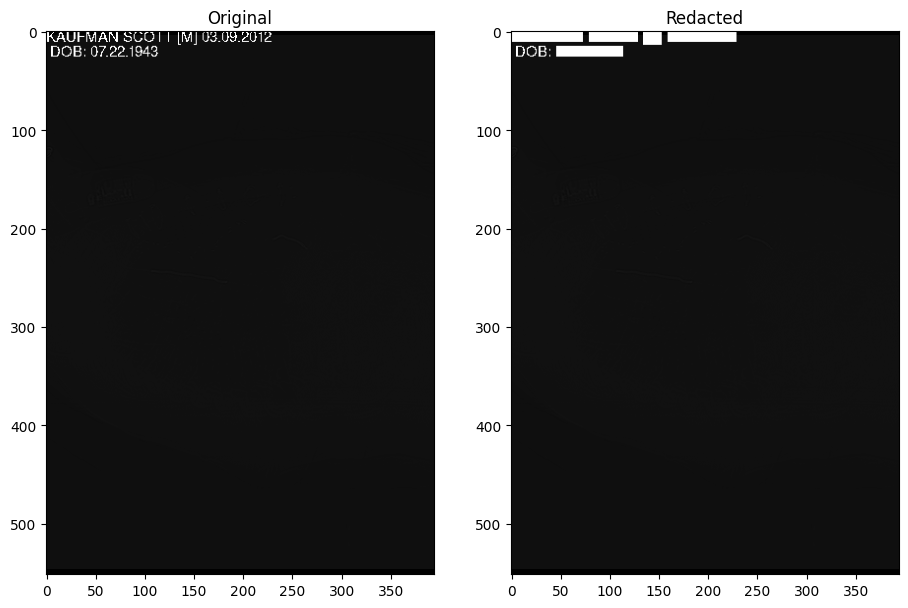

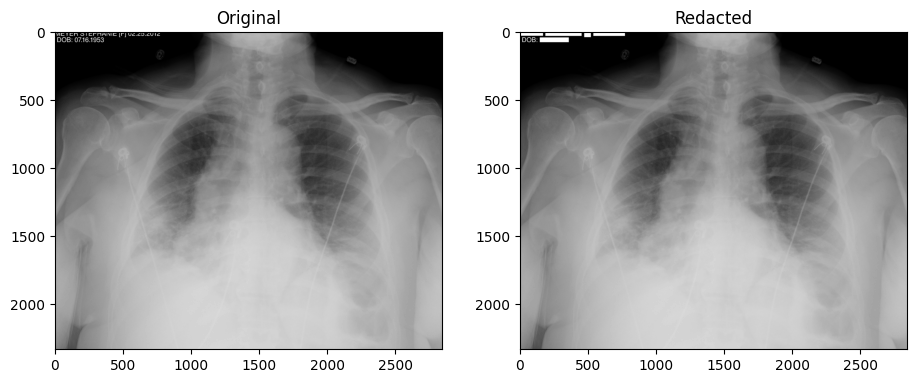

In [24]:
for i in range(0, len(original_files)):
    original_file = pydicom.dcmread(original_files[i])
    redacted_file = pydicom.dcmread(redacted_files[i])
    
    compare_dicom_images(original_file, redacted_file)

# DOTNET LINUX
```
 wget https://download.visualstudio.microsoft.com/download/pr/4e3b04aa-c015-4e06-a42e-05f9f3c54ed2/74d1bb68e330eea13ecfc47f7cf9aeb7/d
otnet-sdk-8.0.404-linux-x64.tar.gz

mkdir -p $HOME/dotnet && tar zxf dotnet-sdk-8.0.404-linux-x64.tar.gz -C $HOME/dotnet
export DOTNET_ROOT=$HOME/dotnet
export PATH=$PATH:$HOME/dotnet
````



In [21]:
# Load in and process your DICOM file as needed
dicom_instance = pydicom.dcmread('sample_data/0_ORIGINAL_anonymized.dcm')

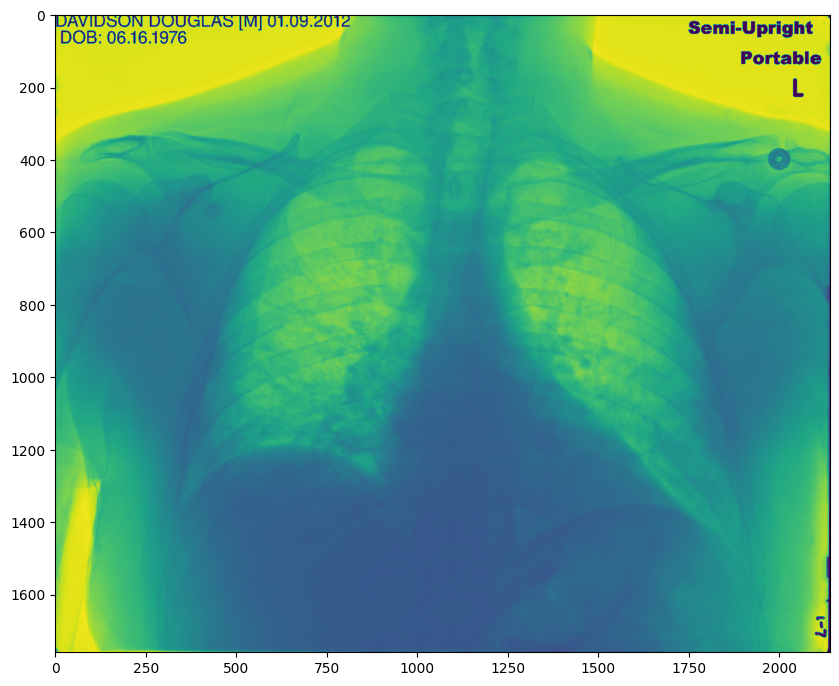

In [22]:
plt.figure(figsize=(10,10))
plt.imshow(dicom_instance.pixel_array)

In [23]:
dicom_instance

Dataset.file_meta -------------------------------
(0002,0000) File Meta Information Group Length  UL: 190
(0002,0001) File Meta Information Version       OB: b'\x00\x01'
(0002,0002) Media Storage SOP Class UID         UI: Computed Radiography Image Storage
(0002,0003) Media Storage SOP Instance UID      UI: 2.25.112784503178059210578740147414000844278
(0002,0010) Transfer Syntax UID                 UI: Implicit VR Little Endian
(0002,0012) Implementation Class UID            UI: 1.3.6.1.4.1.30071.8
(0002,0013) Implementation Version Name         SH: 'fo-dicom 5.1.1'
(0002,0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008,0008) Image Type                          CS: ['DERIVED', 'PRIMARY', 'POST_PROCESSED', 'RT', '', '', '', '', '100000']
(0008,0016) SOP Class UID                       UI: Computed Radiography Image Storage
(0008,0018) SOP Instance UID                    UI: 2.25.58383307561752511099508323636847593103
(0008,002